## Reading and exploring data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
dataset = pd.read_csv("AirPassengers.csv")
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)

In [5]:
from datetime import datetime
indexeddataset = dataset.set_index(['Month'])

In [6]:
indexeddataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


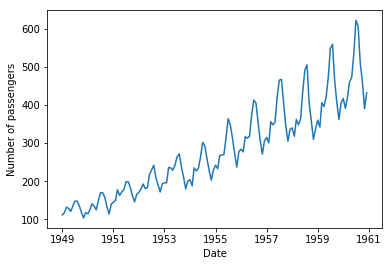

In [7]:
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.plot(indexeddataset)

## Rolling Statistics

In [8]:
rolmean = indexeddataset.rolling(window=12).mean()
rolstd = indexeddataset.rolling(window=12).std()

print(rolmean,rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01   126.666667
1950-01-01   126.916667
1950-02-01   127.583333
1950-03-01   128.333333
1950-04-01   128.833333
1950-05-01   129.166667
1950-06-01   130.333333
1950-07-01   132.166667
1950-08-01   134.000000
1950-09-01   135.833333
1950-10-01   137.000000
1950-11-01   137.833333
1950-12-01   139.666667
1951-01-01   142.166667
1951-02-01   144.166667
1951-03-01   147.250000
1951-04-01   149.583333
1951-05-01   153.500000
1951-06-01   155.916667
...                 ...
1958-07-01   376.333333
1958-08-01   379.500000
1958-09-01   379.500000
1958-10-01   380.500000
1958-11-01   380.916667
1958-12-01   381.000000
1959-01-01   382.666667
1959-02-01   384.666667
1959-03-01   388

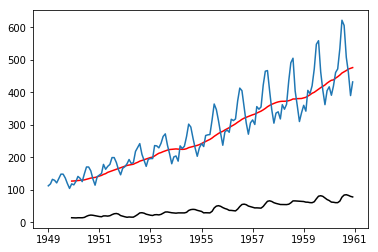

In [9]:
plt.plot(rolmean,color='red')
plt.plot(rolstd, color='black')
plt.plot(indexeddataset)

## ADF Test

In [10]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(indexeddataset['#Passengers'], autolag="AIC")
dfoutput = pd.Series(dftest[:4],index = ['Test Statistc','p-value','#Lags used','No. observations used'])

In [11]:
for key,value in dftest[4].items():
    dfoutput['Critical Value {}'.format(key)] = value

print(dfoutput)

Test Statistc              0.815369
p-value                    0.991880
#Lags used                13.000000
No. observations used    130.000000
Critical Value 1%         -3.481682
Critical Value 5%         -2.884042
Critical Value 10%        -2.578770
dtype: float64


Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In [12]:
def test_stationarity(timeseries):
    #Rolling average
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    plt.plot(rolmean,color='red')
    plt.plot(rolstd, color='black')
    plt.plot(timeseries)
    
    #Dicky Fuller
    dftest = adfuller(timeseries['#Passengers'], autolag="AIC")
    dfoutput = pd.Series(dftest[:4],index = ['Test Statistc','p-value','#Lags used','No. observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value {}'.format(key)] = value

    print(dfoutput)

## Making the TS Stationary

### Applying log transformation

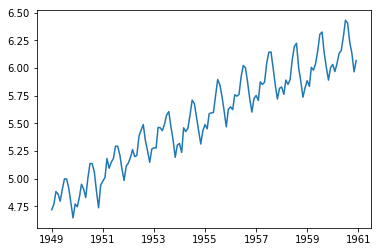

In [13]:
indexeddataset_log = np.log(indexeddataset)
plt.plot(indexeddataset_log)

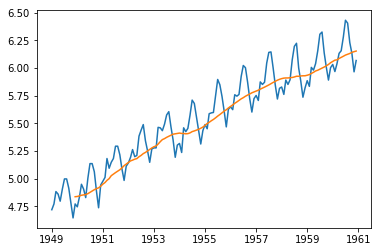

In [14]:
moving_avg = indexeddataset_log.rolling(window=12).mean()
movingSTD = indexeddataset_log.rolling(window=12).std()

plt.plot(indexeddataset_log)
plt.plot(moving_avg)


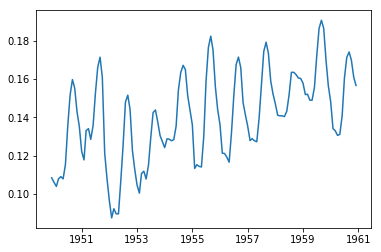

In [15]:
plt.plot(movingSTD)

### Subtracting moving average from actual values (log)

In [16]:
datasetlogminusaverage = indexeddataset_log - moving_avg
datasetlogminusaverage.dropna(inplace=True)
datasetlogminusaverage.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


Test Statistc             -3.162908
p-value                    0.022235
#Lags used                13.000000
No. observations used    119.000000
Critical Value 1%         -3.486535
Critical Value 5%         -2.886151
Critical Value 10%        -2.579896
dtype: float64


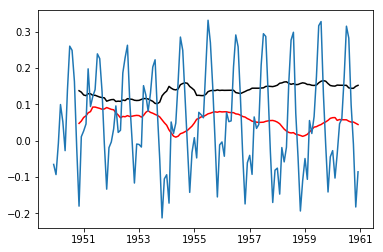

In [17]:
test_stationarity(datasetlogminusaverage)

### Calculating weighted average of time series

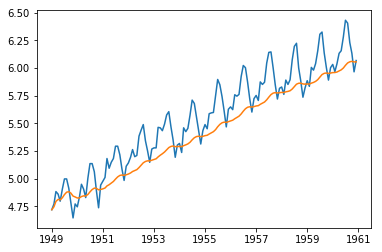

In [18]:
exponentialdecayweightaverage = indexeddataset_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexeddataset_log)
plt.plot(exponentialdecayweightaverage)

Test Statistc             -3.601262
p-value                    0.005737
#Lags used                13.000000
No. observations used    130.000000
Critical Value 1%         -3.481682
Critical Value 5%         -2.884042
Critical Value 10%        -2.578770
dtype: float64


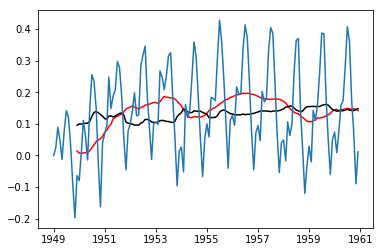

In [19]:
datasetminusweightedaverage = indexeddataset_log - exponentialdecayweightaverage
test_stationarity(datasetminusweightedaverage)

### Subtracting shifted data (differentiating once)

Test Statistc             -2.717131
p-value                    0.071121
#Lags used                14.000000
No. observations used    128.000000
Critical Value 1%         -3.482501
Critical Value 5%         -2.884398
Critical Value 10%        -2.578960
dtype: float64


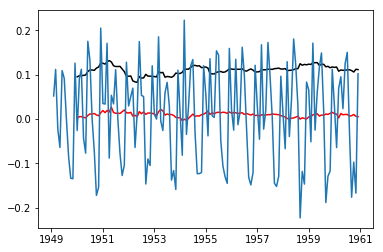

In [20]:
datasetlogdiffshifting = indexeddataset_log - indexeddataset_log.shift(1)
datasetlogdiffshifting.dropna(inplace=True)
test_stationarity(datasetlogdiffshifting)

### Looking at the components of TS

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(indexeddataset_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

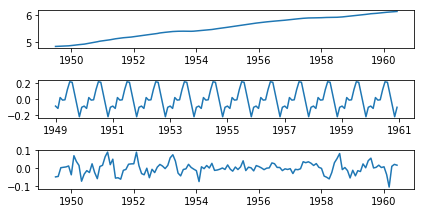

In [22]:
plt.plot(411)
plt.plot(indexeddataset_log)
plt.subplot(412)
plt.plot(trend)
plt.subplot(413)
plt.plot(seasonal)
plt.subplot(414)
plt.plot(residual)
plt.tight_layout()


Test Statistc           -6.332387e+00
p-value                  2.885059e-08
#Lags used               9.000000e+00
No. observations used    1.220000e+02
Critical Value 1%       -3.485122e+00
Critical Value 5%       -2.885538e+00
Critical Value 10%      -2.579569e+00
dtype: float64


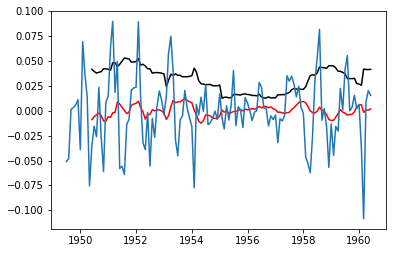

In [23]:
decomposedlogdata = residual
decomposedlogdata.dropna(inplace=True)
test_stationarity(decomposedlogdata)

### Calculating P and Q

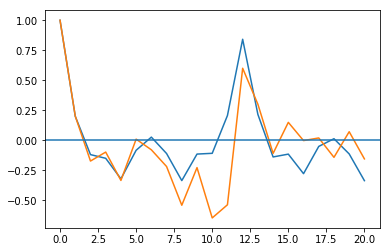

In [24]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetlogdiffshifting, nlags=20)
lag_pacf = pacf(datasetlogdiffshifting, nlags=20, method='ols')

plt.plot(lag_acf)
plt.plot(lag_pacf)
plt.axhline(y=0)

p value is based on where pacf is 0

q value is based on where acf is 0

## ARIMA

/Users/aish.prabhat/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/aish.prabhat/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.5023033686758773')

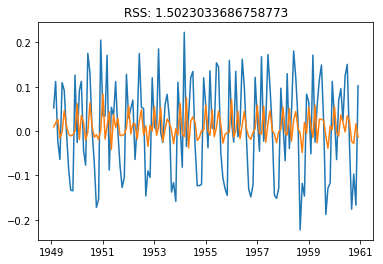

In [25]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(indexeddataset_log, order = (2,1,0))

results_AR = model.fit(disp=-1)
plt.plot(datasetlogdiffshifting)
plt.plot(results_AR.fittedvalues)
plt.title('RSS: {}'.format(sum((results_AR.fittedvalues - 
                               datasetlogdiffshifting['#Passengers'])**2)))

Lower RSS is preferred

/Users/aish.prabhat/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/aish.prabhat/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.4721401333860953')

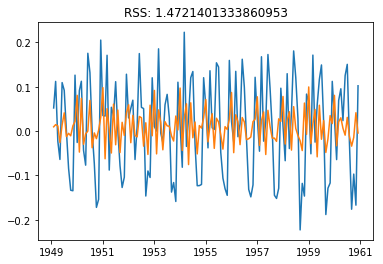

In [26]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(indexeddataset_log, order = (0,1,2))

results_MA = model.fit(disp=-1)
plt.plot(datasetlogdiffshifting)
plt.plot(results_MA.fittedvalues)
plt.title('RSS: {}'.format(sum((results_MA.fittedvalues - 
                               datasetlogdiffshifting['#Passengers'])**2)))

/Users/aish.prabhat/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/aish.prabhat/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 1.0291519993714058')

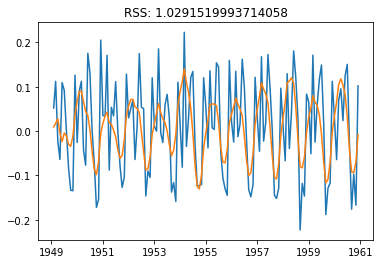

In [27]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(indexeddataset_log, order = (2,1,2))

results_ARIMA = model.fit(disp=-1)
plt.plot(datasetlogdiffshifting)
plt.plot(results_ARIMA.fittedvalues)
plt.title('RSS: {}'.format(sum((results_ARIMA.fittedvalues - 
                               datasetlogdiffshifting['#Passengers'])**2)))

In [45]:
results_ARIMA.fittedvalues

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
1949-07-01   -0.004347
1949-08-01   -0.010978
1949-09-01   -0.029929
1949-10-01   -0.034467
1949-11-01   -0.011279
1949-12-01    0.037212
1950-01-01    0.068135
1950-02-01    0.089434
1950-03-01    0.090029
1950-04-01    0.066152
1950-05-01    0.044053
1950-06-01    0.035467
1950-07-01    0.003100
1950-08-01   -0.047127
1950-09-01   -0.086353
1950-10-01   -0.098465
1950-11-01   -0.067846
1950-12-01   -0.005228
1951-01-01    0.017385
1951-02-01    0.034016
1951-03-01    0.042561
1951-04-01    0.018748
1951-05-01    0.015260
1951-06-01    0.002489
1951-07-01   -0.012408
                ...   
1958-07-01    0.054477
1958-08-01   -0.016465
1958-09-01   -0.079841
1958-10-01   -0.083143
1958-11-01   -0.058870
1958-12-01   -0.002663
1959-01-01    0.031199
1959-02-01    0.051445
1959-03-01    0.079806
1959-04-01    0.065334
1959-05-01    0.058190
1959-06-01    0.036074
1959-

In [28]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff.head()


Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

### Untransforming data

In [29]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [30]:
predictions_ARIMA_log = pd.Series(indexeddataset_log['#Passengers'].iloc[0],
                                 index = indexeddataset_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,
                                                 fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

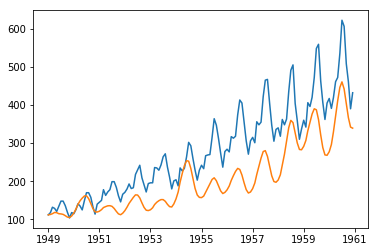

In [31]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexeddataset)
plt.plot(predictions_ARIMA)

In [32]:
predictions_ARIMA.head()

Month
1949-01-01    112.000000
1949-02-01    113.078121
1949-03-01    115.073419
1949-04-01    118.302007
1949-05-01    117.768385
dtype: float64

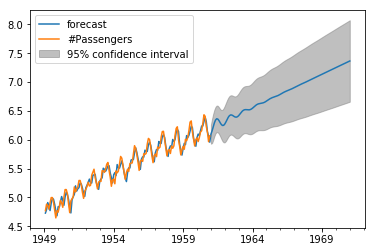

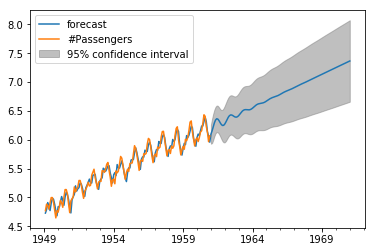

In [33]:
results_ARIMA.plot_predict(1,264)

In [103]:
x = results_ARIMA.forecast(144)

In [104]:
x = np.exp(x[0])
x

array([ 443.87081023,  470.03795604,  504.93468387,  540.45459736,
        567.73064592,  580.32822822,  577.0029063 ,  561.9391297 ,
        542.38482965,  525.56677422,  516.65899494,  518.14300776,
        529.93682081,  549.71643418,  573.36042649,  595.78888652,
        612.33154639,  620.24264691,  619.59569618,  613.03686491,
        604.59665396,  598.26627221,  596.94822937,  601.96209045,
        612.98247268,  628.25967956,  645.0797936 ,  660.46207355,
        671.98846324,  678.50400449,  680.39656021,  679.34138615,
        677.65954476,  677.58599907,  680.69796357,  687.6108227 ,
        697.93650296,  710.46173741,  723.5015754 ,  735.36365512,
        744.81248077,  751.39211715,  755.49840392,  758.1876954 ,
        760.81213515,  764.62025872,  770.44205447,  778.52242141,
        788.5159716 ,  799.62429779,  810.83600184,  821.20980476,
        830.12555798,  837.43150117,  843.44752762,  848.83370785,
        854.37710048,  860.76824645,  868.42928358,  877.43033

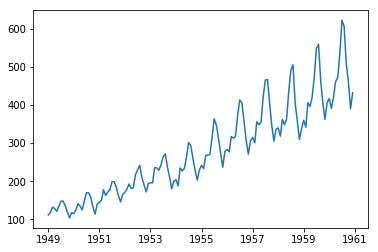

In [93]:
plt.plot(indexeddataset)

In [105]:
x = pd.Series(x,copy=True)


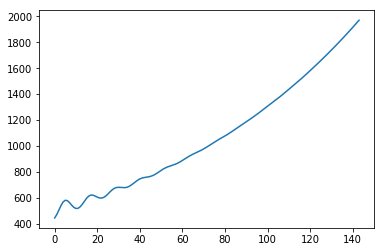

In [110]:
plt.plot(x)